In [1]:
from __future__ import division
import numpy as np
import scipy
import scipy.stats as sps
import scipy.fftpack as spfft
import scipy.signal as spsig
import math
import matplotlib.pyplot as plt
import matplotlib
from mpl_toolkits.axes_grid1.inset_locator import (inset_axes, InsetPosition,
                                                  mark_inset)
import um21_lagmodel as uml
#%matplotlib inline
%matplotlib notebook

# Set up list of colours that are more colour-blind accessible.
CBcol = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

In [2]:
# Set up starting parameters:
############################################
### Basic geometry and radial binning: #####
############################################
cor_geometry = uml.an_sphere
rin = 2.0  # Innermost radius for viscous dissipation (ISCO)
rout = 300.0 # Outermost radius for viscous dissipation - best to set large but with smaller rsigmax 
# to make linear rebinned IRFs manageable
nrad = 200 # Number of radial bins for viscous dissipation
rcor = 10.0 # Outer radius of corona and inner radius of blackbody emitting disk
hcor = 10.0 # Height of corona (for cylindrical or inverted cone coronal shapes)
cone_angle = 30.0  # Cone opening angle in degrees
#rtop = rcor + hcor*np.tan(np.pi*(cone_angle/180))
#print("Coronal top radius : ",rtop)
geopar = [rcor]
################################################################################
### 'Timing model' parameters for driving signal generation and propagation ####
################################################################################
rsigmax = 300.0 # Maximum radius for inward-propagating signals to start from
t_scale= 5e-5 # Scaling between Rg/c units and actual time units (e.g. for timing in seconds, this is Rg/c in seconds,
# e.g. 5e-5 for a 10 solar mass BH)
min_deltau_frac = 0.25 # Minimum bin size (fraction of minimum propagation delay across a bin)
disk_tau_par = [100.,0.] # Variability time-scale at radius r is disk_tau_par[0]*((r/rcor)^disk_tau_par[1])*r^1.5
cor_tau_par = [100., 0.] # As disk_tau_par but for signal time-scales generated in the corona
disk_prop_par = [100.,0.] # Radial propagation time delay across a radial bin of width dr at radius r
# is deltau = dr*(disk_prop_par[0]*(r/rcor)^disk_prop_par[1])*sqrt(r)
cor_prop_par = [0., 0.] # As disk_prop_par but for radial propagation delays generated in the corona

lor_model = 'continuous' # Driving signals are split across all radial bins to rsigmax (equivalent to basic Lyubarskii 
                         # model with mdot fluctuations at all radii)
lor_par = [1.0,0.4,0.0] # For continuous model: [q,total_rms_in_disk,total_rms_in_corona], if the last parameter is 
                        # < 0, the total_rms_in_disk is split evenly across corona and disk radii
nirf_mult = 8 # IRF is this (must be power of 2) times bigger than next highest power of 2 bins corresponding to 
#  propagation time from max. signal radius.  Set high enough to ensure entire useful frequency range can be covered.

###########################################################################################
### 'Spectral model' parameters for disk absorbed flux and seed and heating in corona, ####
### photon index dependence on L_s/L_h and choice of energies for power-law fluxes and ####
### observed disk band. ###################################################################
###########################################################################################

disk_abs_frac = 0.7 # Fraction of incident flux on disk which is reprocessed into blackbody emission (= 1-albedo)
heatff_norm = 1.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into heating the corona (heat_frac_flow)
heatff_ind = 0.0 # Index for radial dependence of heat_frac_flow 
seedff_norm = 0.0 # Normalisation parameter for power-law function describing radial dependence of fraction 
# of energy dissipated in coronal flow which goes into internal seed photons (seed_frac_flow)
# should be set to zero if using full energy-dependent model, as assumed internal seed spectrum 
# not yet implemented. Set to < 0 if you require seed_frac_flow = 1.-heat_frac_flow
seedff_ind = 0.0 # Index for radial dependence of seed_frac_flow 
gamma_par = [2.33,0.167] # gamma = gamma_par[0]*(L_s/L_h)^(gamma_par[1])
e_seed = 1.0
# Choose power-law energies for analytical calculation using mono-energetic bands 
# (must be equal or greater than e_seed):
ens_mono = np.array([1.,3.,9.,27.])*e_seed
# Specify pairs of energy bands to use for spectral-timing measurements. Band 0 is the disk, larger indices
# i corresponds to index i-1 in the array of monoenergetic bands for power-law analysis.
encomb = np.array([[2,0],[3,2],[4,3]])


In [ ]:
cor_geometry = uml.an_sphere
radlist = [6.0,10.0,20.0]
ls_list = ['solid','dashed','dotted']
vlines_list = []
laglist = []
psdlist = []
for i, radval in enumerate(radlist):
    rcor = radval
    geopar = [rcor]
    gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, deltau, ldisk_disp, lseed_disp,\
        lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd = \
    uml.run_stprod_mono(rin,rout,nrad,rcor,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)
    for j in range(3):
        if j == 0:
            labtxt = r"$r_{\rm cor}$="+str(round(radval))+" $R_{g}$"
        else:
            labtxt = None
        laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[i],ls_list[j],labtxt])
        if j == 0:
            psdlist.append([np.copy(freq),psd_ref[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
        else:
            psdlist.append([np.copy(freq),psd_ci[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
    vlines_list.append([1./(tau[i_rcor]*t_scale),CBcol[i],'dashdot'])
    
freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.022,0.01]
psdlim = [0.01,2.0]
inset_yticks = [-0.02,-0.01,0]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
leg_title = 'Spherical'
#figfile = 'figs/lagspsd_sphericalmono_rcorcompare.pdf'
figfile = None
uml.plot_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, figfile)

Coronal radius reset to nearest radial bin edge:  6.02240659026927
Maximum signal radius reset to:  296.265462867623
0.22268746127793365  of the disk flux is intercepted by the corona
0.2827663506972335  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.6060480538363964
Dissipation seed luminosity:  0.13495930252125954
Coronal heating luminosity:  0.39395194616360363
Disk luminosity due to heating by corona:  0.14955830363333572
Seed luminosity due to heating by corona:  0.041348791395917156
Mean gamma is: 2.0372501761303563
#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  0.00047162804218296066
The maximum propagation delay is:  17.270679010815904  and there are  524288  irf bins.
CI mean, ref mean, CI outer, ref outer :  1.0 0.7556062595870265 0.0 0.0
Calculated for energies  [2 0]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 0.0 0.0
Calculated for energies  [3 2]
CI m

<IPython.core.display.Javascript object>


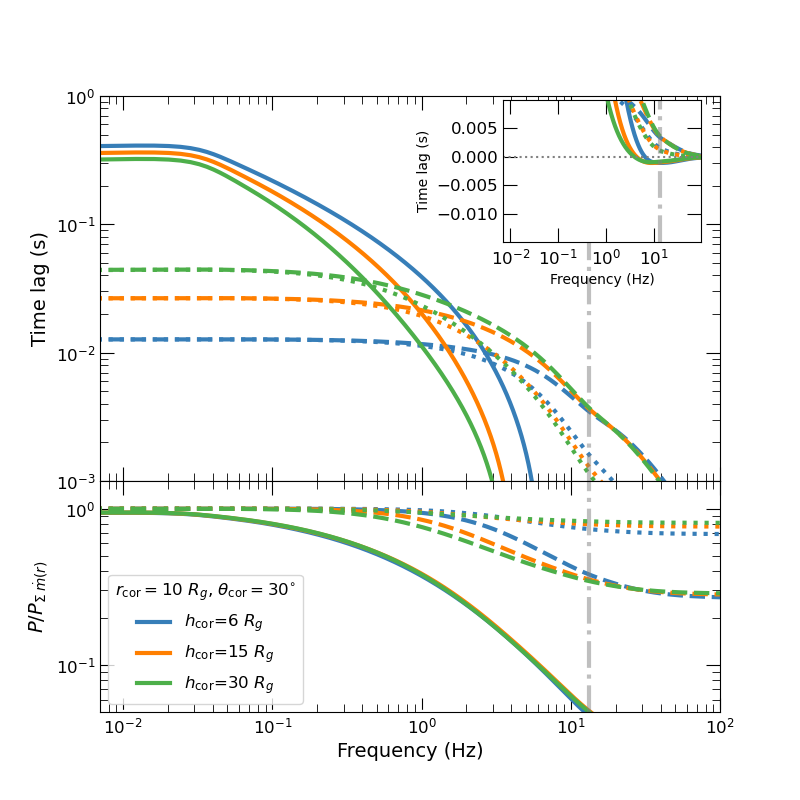

In [13]:
cor_geometry = uml.inv_cone
rcor = 10.0
hcorlist = [6.0,15.0,30.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [30.,30.,30.]  # Cone opening angle in degrees
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
ls_list = ['solid','dashed','dotted']

vlines_list = []
laglist = []
psdlist = []

disk_abs_frac = 0.7

for i, hcorval in enumerate(hcorlist):
    geopar = [rcor,hcorval,rtoplist[i],1000,1000]
    gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, deltau, ldisk_disp, lseed_disp,\
        lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd = \
    uml.run_stprod_mono(rin,rout,nrad,rcor,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)
    for j in range(3):
        if j == 0:
            labtxt = r"$h_{\rm cor}$="+str(round(hcorval))+" $R_{g}$"
        else:
            labtxt = None
        laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[i],ls_list[j],labtxt])
        if j == 0:
            psdlist.append([np.copy(freq),psd_ref[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
        else:
            psdlist.append([np.copy(freq),psd_ci[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])


freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.015,0.01]
psdlim = [0.05,1.5]
inset_yticks = [-0.01,-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
#figfile = 'figs/lagspsd_invcone_mono_hcorcompare.pdf'
figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'

uml.plot_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, figfile)    


In [ ]:
cor_geometry = uml.inv_cone
rcorlist = [6.0,10.0,20.0]
hcorlist = [10.0,10.0,10.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [30.,30.,30.]  # Cone opening angle in degrees
rtoplist = np.array(rcorlist) + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
ls_list = ['solid','dashed','dotted']

vlines_list = []
laglist = []
psdlist = []
for i, rcorval in enumerate(rcorlist):
    geopar = [rcorval,hcorlist[i],rtoplist[i],1000,1000]
    gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, deltau, ldisk_disp, lseed_disp,\
        lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd = \
    uml.run_stprod_mono(rin,rout,nrad,rcorval,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)
    for j in range(3):
        if j == 0:
            labtxt = r"$r_{\rm cor}$="+str(round(rcorval))+" $R_{g}$"
        else:
            labtxt = None
        laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[i],ls_list[j],labtxt])
        if j == 0:
            psdlist.append([np.copy(freq),psd_ref[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
        else:
            psdlist.append([np.copy(freq),psd_ci[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
        
    vlines_list.append([1./(tau[i_rcor]*t_scale),CBcol[i],'dashdot'])


freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.015,0.01]
psdlim = [0.01,2.0]
inset_yticks = [-0.01,-0.005,0,0.005]
axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
#figfile = 'figs/lagspsd_invcone_mono_rcorcompare.pdf'
figfile = None
leg_title=r'$h_{\rm cor}=10$ $R_{g}$, $\theta_{\rm cor}=30^{\circ}$'

uml.plot_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, figfile)    

Coronal radius reset to nearest radial bin edge:  9.939835534143139
Maximum signal radius reset to:  296.265462867623
0.11739804475974155  of the disk flux is intercepted by the corona
0.0  of the coronal flux is intercepted by the disk
Seed energy : 1.0
Dissipation disk luminosity:  0.41197833971469366
Dissipation seed luminosity:  0.048365451565869605
Coronal heating luminosity:  0.5880216602853063
Disk luminosity due to heating by corona:  0.0
Seed luminosity due to heating by corona:  0.0
Mean gamma is: 1.5352694997959073
#######################################
Calculating mono-energetic spectral-timing products
Time bin size dt is:  0.0010000306442932059
The maximum propagation delay is:  17.215485885700527  and there are  262144  irf bins.
CI mean, ref mean, CI outer, ref outer :  1.0 0.41197762761200846 0.0 0.0
Calculated for energies  [2 0]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 0.0 0.0
Calculated for energies  [3 2]
CI mean, ref mean, CI outer, ref outer :  1.0 1.0 

<IPython.core.display.Javascript object>


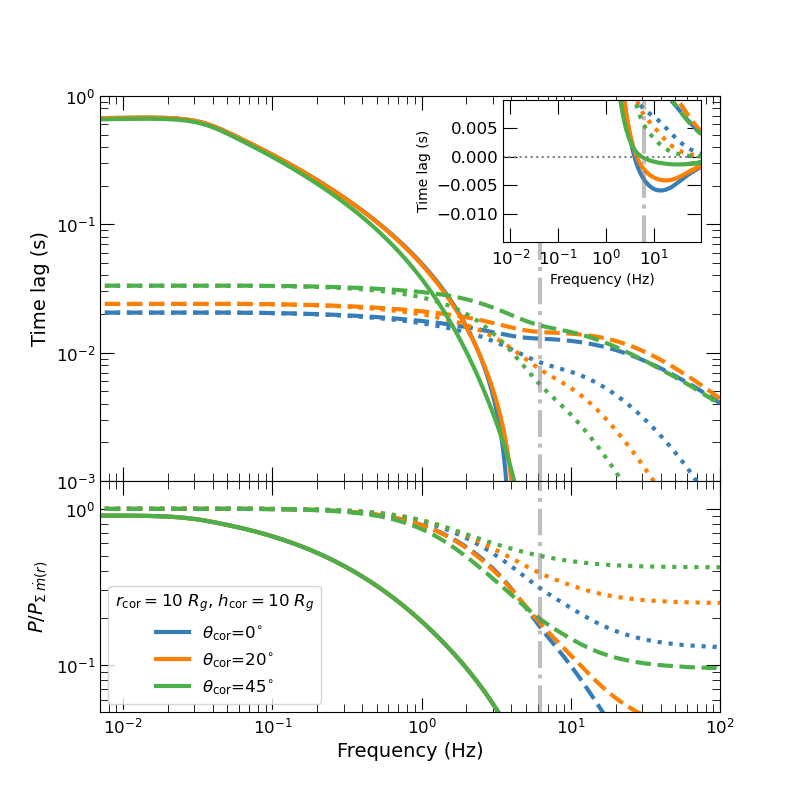

In [4]:
cor_geometry = uml.inv_cone
rcor = 10.0
hcorlist = [10.0,10.0,10.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [0.,20.,45.]  # Cone opening angle in degrees
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
ls_list = ['solid','dashed','dotted']

vlines_list = []
laglist = []
psdlist = []

disk_abs_frac = 0.

for i, hcorval in enumerate(hcorlist):
    geopar = [rcor,hcorval,rtoplist[i],1000,1000]
    gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, deltau, ldisk_disp, lseed_disp,\
        lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd = \
    uml.run_stprod_mono(rin,rout,nrad,rcor,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)
    for j in range(3):
        if j == 0:
            labtxt = r"$\theta_{\rm cor}$="+str(round(angle_list[i]))+"$^{\circ}$"
        else:
            labtxt = None
        laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[i],ls_list[j],labtxt])
        if j == 0:
            psdlist.append([np.copy(freq),psd_ref[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
        else:
            psdlist.append([np.copy(freq),psd_ci[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])


axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.015,0.01]
psdlim = [0.05,1.5]
inset_yticks = [-0.01,-0.005,0,0.005]
#figfile = 'figs/lagspsd_invcone_mono_thetacorcompare.pdf'
figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $h_{\rm cor}=10$ $R_{g}$'

uml.plot_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, figfile)    


In [ ]:
cor_geometry = uml.inv_cone
rcor = 10.0
hcorlist = [30.0,30.0,30.0] # Height of corona (for cylindrical or inverted cone coronal shapes)
angle_list = [0.,30.,45.]  # Cone opening angle in degrees
rtoplist = rcor + np.array(hcorlist)*np.tan(np.pi*(np.array(angle_list)/180))
ls_list = ['solid','dashed','dotted']

vlines_list = []
laglist = []
psdlist = []
for i, hcorval in enumerate(hcorlist):
    geopar = [rcor,hcorval,rtoplist[i],1000,1000]
    gamma_mean, freq, phlag, tlag, psd_ci, psd_ref, tau, i_rcor, i_rsigmax, deltau, ldisk_disp, lseed_disp,\
        lheat, ldisk_rev, lseed_rev, flux_irf_mono, mod_sig_psd = \
    uml.run_stprod_mono(rin,rout,nrad,rcor,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,cor_geometry,
                    geopar,disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)
    for j in range(3):
        if j == 0:
            labtxt = r"$\theta_{\rm cor}$="+str(round(angle_list[i]))+"$^{\circ}$"
        else:
            labtxt = None
        laglist.append([np.copy(freq),np.copy(tlag[j,:]),CBcol[i],ls_list[j],labtxt])
        if j == 0:
            psdlist.append([np.copy(freq),psd_ref[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
        else:
            psdlist.append([np.copy(freq),psd_ci[j,:]/mod_sig_psd[0,:],CBcol[i],ls_list[j],labtxt])
vlines_list.append([1./(tau[i_rcor]*t_scale),'gray','dashdot'])


axis_names = ['Frequency (Hz)','Time lag (s)',r'$P/P_{\Sigma \; \dot{m}(r)}$']
freqlim = [0.007,100.0]
tlaglim = [0.001,1]
tlaglim_in = [-0.015,0.01]
psdlim = [0.05,1.5]
inset_yticks = [-0.01,-0.005,0,0.005]
#figfile = 'figs/lagspsd_invcone_mono_thetacorcomparehc30Rg.pdf'
figfile = None
leg_title=r'$r_{\rm cor}=10$ $R_{g}$, $h_{\rm cor}=30$ $R_{g}$'

uml.plot_lags_psds(laglist, psdlist, vlines_list, axis_names, freqlim, tlaglim, tlaglim_in, psdlim, 
               inset_yticks, leg_title, figfile)    

In [ ]:
cor_geometry = uml.an_sphere
nirf_mult = 2
rad_edge2 = np.logspace(np.log10(rin), np.log10(rout), nrad+1)  # set up radial bin edges
rad2 = np.sqrt(rad_edge2[1:]*rad_edge2[:-1])  # Define radial bin centres as geometric mean of bin edges
radlist = rad2[36:108:2]
geom_list = []
for i, radval in enumerate(radlist):
    geom_list.append([cor_geometry,radval,0.,0.])

geom_params_sph = uml.geom_params_calc(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)

#np.save('data/geom_params_sph',geom_params_sph)

In [ ]:
cor_geometry = uml.inv_cone
nirf_mult = 2
rcor = 10.
angles_list = np.linspace(0.0,45.0,20)
hcors_list = np.geomspace(5.,30.,20)
hcor_lines = [5.,10.,20.,30.]
angle_lines = [0.,15.,30.,45.]
geom_list = []
for hcor in hcor_lines:
    for angle in angles_list:
        geom_list.append([cor_geometry,rcor,hcor,angle])
for angle in angle_lines:
    for hcor in hcors_list:
        geom_list.append([cor_geometry,rcor,hcor,angle])   
    
geom_params_ic10 = \
            uml.geom_params_calc(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)

#np.save('data/geom_params_ic10',geom_params_ic10)


cor_geometry = uml.inv_cone
nirf_mult = 2
rcor = 20.
angles_list = np.linspace(0.0,45.0,20)
hcors_list = np.geomspace(5.,30.,20)
hcor_lines = [5.,10.,20.,30.]
angle_lines = [0.,15.,30.,45.]
geom_list = []
for hcor in hcor_lines:
    for angle in angles_list:
        geom_list.append([cor_geometry,rcor,hcor,angle])
for angle in angle_lines:
    for hcor in hcors_list:
        geom_list.append([cor_geometry,rcor,hcor,angle])   
    
geom_params_ic20 = \
            uml.geom_params_calc(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)

#np.save('data/geom_params_ic20',geom_params_ic20)

cor_geometry = uml.inv_cone
nirf_mult = 2
rcor = 6.
angles_list = np.linspace(0.0,45.0,20)
hcors_list = np.geomspace(5.,30.,20)
hcor_lines = [5.,10.,20.,30.]
angle_lines = [0.,15.,30.,45.]
geom_list = []
for hcor in hcor_lines:
    for angle in angles_list:
        geom_list.append([cor_geometry,rcor,hcor,angle])
for angle in angle_lines:
    for hcor in hcors_list:
        geom_list.append([cor_geometry,rcor,hcor,angle])   
    
geom_params_ic6 = \
            uml.geom_params_calc(rin,rout,nrad,rsigmax,seedff_norm,seedff_ind,heatff_norm,heatff_ind,geom_list,
                    disk_abs_frac,t_scale,disk_tau_par,cor_tau_par,lor_model,lor_par,
                    disk_prop_par,cor_prop_par,gamma_par,e_seed,ens_mono,encomb,nirf_mult,min_deltau_frac)

#np.save('data/geom_params_ic6',geom_params_ic6)



In [3]:
geom_params_sph = np.load('data/geom_params_sph.npy')
geom_params_ic6 = np.load('data/geom_params_ic6.npy')
geom_params_ic10 = np.load('data/geom_params_ic10.npy')
geom_params_ic20 = np.load('data/geom_params_ic20.npy')

# convert the minimum (negative) disk-PL lags into positive values
for geom_params in [geom_params_sph,geom_params_ic6,geom_params_ic10,geom_params_ic20]:
    geom_params[:,6] = -1.*geom_params[:,6]


<IPython.core.display.Javascript object>


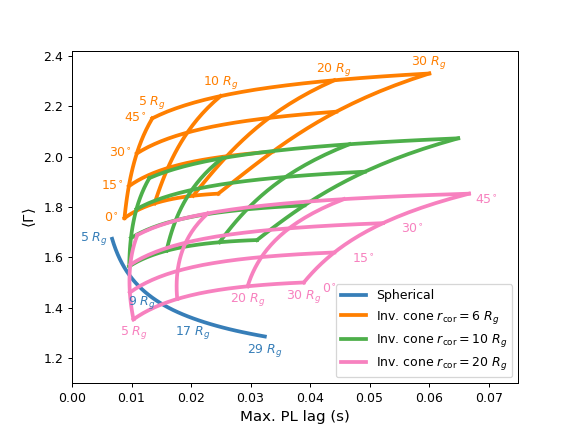

<IPython.core.display.Javascript object>


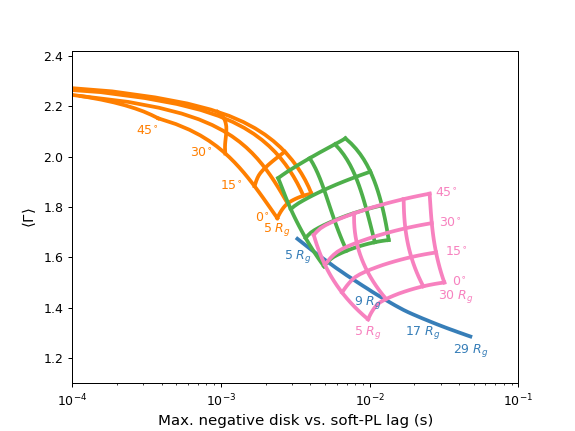

In [4]:
rad_edge2 = np.logspace(np.log10(rin), np.log10(rout), nrad+1)  # set up radial bin edges
rad2 = np.sqrt(rad_edge2[1:]*rad_edge2[:-1])  # Define radial bin centres as geometric mean of bin edges
radlist = rad2[36:108:2]
radselect = [0,len(radlist)//3,2*len(radlist)//3,-1]
hcor_lines = [5.,10.,20.,30.]
angle_lines = [0.,15.,30.,45.]

txt_sph = [radlist[radselect],np.array([[-0.003,0.],[0,-0.02],[0,-0.02],[0,-0.02]]),['center','center','center','center'],
           ['center','top','top','top']]
txt_ic6 = [['upper','upper','upper','upper','lower','lower','lower','lower'],
           np.array([[0,0.03],[0,0.02],[0,0.01],[0,0.01],[-0.001,0],[-0.001,0],[-0.001,0],[-0.001,0]]),
           ['center','center','center','center','right','right','right','right'],
           ['bottom','bottom','bottom','bottom','center','center','center','center']]
txt_ic10 = None
txt_ic20 = [['lower','off','lower','lower','upper','upper','upper','upper'],
           np.array([[0,-0.02],[0,-0.02],[0,-0.02],[0,-0.02],[0.003,0],[0.003,0],[0.003,0],[0.001,0]]),
           ['center','center','center','center','left','left','left','left'],
           ['top','top','top','top','top','top','top','top']]

input_lists = [[geom_params_sph,txt_sph,CBcol[0],'Spherical',None,None],
               [geom_params_ic6,txt_ic6,CBcol[1],r'Inv. cone $r_{\rm cor}=6$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic10,txt_ic10,CBcol[2],r'Inv. cone $r_{\rm cor}=10$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic20,txt_ic20,CBcol[3],r'Inv. cone $r_{\rm cor}=20$ $R_{g}$',hcor_lines,angle_lines]]


xcol = 5
xlabel_val = r'Max. PL lag (s)'
xlim_vals = ([0.0,0.075],'linear')
ycol = 3
ylabel_val = r'$\langle \Gamma \rangle$'
ylim_vals = ([1.1,2.42],'linear')
#figfile = 'figs/params_gamma_vs_PLPLlag.pdf'
figfile = None

uml.plot_stparams_grid(input_lists,xcol,ycol,xlim_vals,ylim_vals,xlabel_val,ylabel_val,True,'best',figfile)


txt_sph = [radlist[radselect],np.array([[0,-0.07],[0,-0.02],[0,-0.02],[0,-0.02]]),['center','center','center','center'],
           ['center','top','top','top']]
txt_ic6 = [['lower','off','off','off','lower','lower','lower','lower'],
           np.array([[0,-0.01],[0,0],[0,0],[0,0],[-3e-4,0],[-3e-4,0],[-2e-4,0],[0,-0.025]]),
           ['center','center','center','center','right','right','right','right'],
           ['top','bottom','bottom','bottom','center','center','center','top']]
txt_ic10 = None
txt_ic20 = [['lower','off','off','lower','upper','upper','upper','upper'],
           np.array([[0,-0.02],[0,-0.02],[0,-0.02],[-0.003,-0.02],[0.004,0],[0.004,0],[0.003,0],[0.002,0]]),
           ['center','center','center','left','left','left','left','left'],
           ['top','top','top','top','center','center','center','center']]

input_lists = [[geom_params_sph,txt_sph,CBcol[0],'Spherical',None,None],
               [geom_params_ic6,txt_ic6,CBcol[1],r'Inv. cone $r_{\rm cor}=6$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic10,txt_ic10,CBcol[2],r'Inv. cone $r_{\rm cor}=10$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic20,txt_ic20,CBcol[3],r'Inv. cone $r_{\rm cor}=20$ $R_{g}$',hcor_lines,angle_lines]]

xcol = 6
xlabel_val = r'Max. negative disk vs. soft-PL lag (s)'
xlim_vals = ([0.0001,0.1],'log')
ycol = 3
ylabel_val = r'$\langle \Gamma \rangle$'
ylim_vals = ([1.1,2.42],'linear')
#figfile = 'figs/params_gamma_vs_diskPLlag.pdf'
figfile = None

uml.plot_stparams_grid(input_lists,xcol,ycol,xlim_vals,ylim_vals,xlabel_val,ylabel_val,False,'best',figfile)


<IPython.core.display.Javascript object>


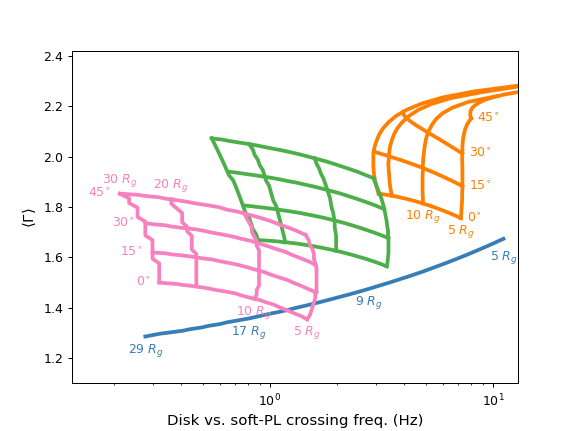

<IPython.core.display.Javascript object>


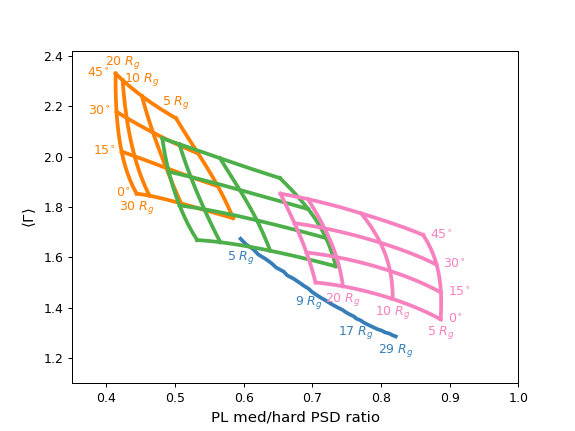

In [5]:
txt_sph = [radlist[radselect],np.array([[0,-0.04],[0,-0.02],[0,-0.02],[0,-0.02]]),['center','center','center','center'],
           ['top','top','top','top']]
txt_ic6 = [['lower','lower','off','off','lower','lower','lower','lower'],
           np.array([[0,-0.02],[0,-0.02],[0,-0.02],[0,-0.02],[0.5,0],[0.5,0],[0.5,0],[0.5,0]]),
           ['center','center','center','center','left','left','left','left'],
           ['top','top','top','top','center','center','center','center']]
txt_ic10 = None
txt_ic20 = [['lower','lower','upper','upper','upper','upper','upper','upper'],
           np.array([[0,-0.02],[0,-0.02],[0,0.02],[0,0.02],[-0.03,0],[-0.03,0],[-0.03,0],[-0.02,0]]),
           ['center','center','center','center','right','right','right','right'],
           ['top','top','bottom','bottom','center','center','center','center']]

input_lists = [[geom_params_sph,txt_sph,CBcol[0],'Spherical',None,None],
               [geom_params_ic6,txt_ic6,CBcol[1],r'Inv. cone $r_{\rm cor}=6$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic10,txt_ic10,CBcol[2],r'Inv. cone $r_{\rm cor}=10$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic20,txt_ic20,CBcol[3],r'Inv. cone $r_{\rm cor}=20$ $R_{g}$',hcor_lines,angle_lines]]

xcol = 7
xlabel_val = r'Disk vs. soft-PL crossing freq. (Hz)'
xlim_vals = ([0.13,13.0],'log')
ycol = 3
ylabel_val = r'$\langle \Gamma \rangle$'
ylim_vals = ([1.1,2.42],'linear')
#figfile = 'figs/params_gamma_vs_fcross.pdf'
figfile = None

uml.plot_stparams_grid(input_lists,xcol,ycol,xlim_vals,ylim_vals,xlabel_val,ylabel_val,False,'best',figfile)


txt_sph = [radlist[radselect],np.array([[0,-0.04],[0,-0.02],[0,-0.02],[0,-0.02]]),['center','center','center','center'],
           ['top','top','top','top']]
txt_ic6 = [['upper','upper','upper','lower','upper','upper','upper','upper'],
           np.array([[0,0.03],[0,0.03],[0,0.035],[0,-0.02],[-0.01,0],[-0.01,0],[-0.01,0],[-0.01,0]]),
           ['center','center','center','center','right','right','right','right'],
           ['bottom','bottom','bottom','top','center','center','center','center']]
txt_ic10 = None
txt_ic20 = [['lower','lower','lower','off','lower','lower','lower','lower'],
           np.array([[0,-0.02],[0,-0.02],[0,-0.02],[0,-0.02],[0.01,0],[0.01,0],[0.01,0],[0.01,0]]),
           ['center','center','center','center','left','left','left','left'],
           ['top','top','top','top','center','center','center','center']]

input_lists = [[geom_params_sph,txt_sph,CBcol[0],'Spherical',None,None],
               [geom_params_ic6,txt_ic6,CBcol[1],r'Inv. cone $r_{\rm cor}=6$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic10,txt_ic10,CBcol[2],r'Inv. cone $r_{\rm cor}=10$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic20,txt_ic20,CBcol[3],r'Inv. cone $r_{\rm cor}=20$ $R_{g}$',hcor_lines,angle_lines]]

xcol = 9
xlabel_val = r'PL med/hard PSD ratio'
xlim_vals = ([0.35,1.0],'linear')
ycol = 3
ylabel_val = r'$\langle \Gamma \rangle$'
ylim_vals = ([1.1,2.42],'linear')
#figfile = 'figs/params_gamma_vs_psdratio.pdf'
figfile = None

uml.plot_stparams_grid(input_lists,xcol,ycol,xlim_vals,ylim_vals,xlabel_val,ylabel_val,False,'best',figfile)

<IPython.core.display.Javascript object>


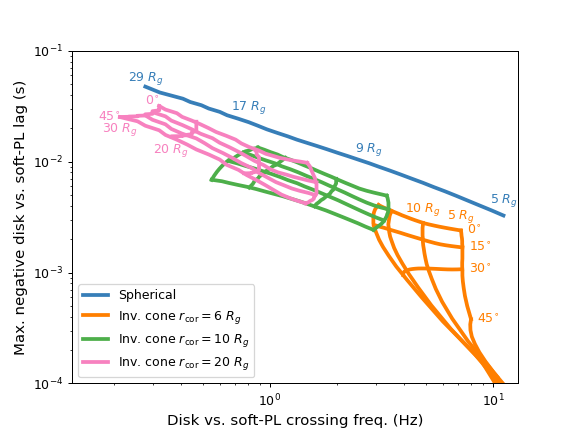

<IPython.core.display.Javascript object>


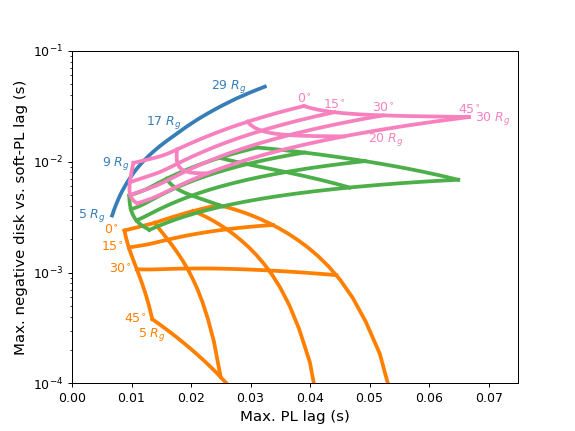

In [6]:
txt_sph = [radlist[radselect],np.array([[0,0.0005],[0,0.001],[0,0.003],[0,0]]),['center','center','center','center'],
           ['bottom','bottom','bottom','bottom']]
txt_ic6 = [['lower','lower','off','off','lower','lower','lower','lower'],
           np.array([[0,0.0003],[0,0.0003],[0,0],[0,0],[0.5,0],[0.5,0],[0.5,0],[0.5,0]]),
           ['center','center','center','center','left','left','left','left'],
           ['bottom','bottom','top','top','center','center','center','center']]
txt_ic10 = None
txt_ic20 = [['off','off','upper','upper','upper','off','off','upper'],
           np.array([[0,0],[0,0],[0,-0.002],[0,-0.002],[0,-0.001],[0,0],[0,0],[0,0]]),
           ['center','center','center','center','right','right','right','right'],
           ['top','top','top','top','bottom','center','center','center']]

input_lists = [[geom_params_sph,txt_sph,CBcol[0],'Spherical',None,None],
               [geom_params_ic6,txt_ic6,CBcol[1],r'Inv. cone $r_{\rm cor}=6$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic10,txt_ic10,CBcol[2],r'Inv. cone $r_{\rm cor}=10$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic20,txt_ic20,CBcol[3],r'Inv. cone $r_{\rm cor}=20$ $R_{g}$',hcor_lines,angle_lines]]

xcol = 7
xlabel_val = r'Disk vs. soft-PL crossing freq. (Hz)'
xlim_vals = ([0.13,13.0],'log')
ycol = 6
ylabel_val = r'Max. negative disk vs. soft-PL lag (s)'
ylim_vals = ([0.0001,0.1],'log')
#figfile = 'figs/params_diskPLlag_vs_fcross.pdf'
figfile = None

uml.plot_stparams_grid(input_lists,xcol,ycol,xlim_vals,ylim_vals,xlabel_val,ylabel_val,True,'lower left',figfile)

txt_sph = [radlist[radselect],np.array([[-0.001,0],[-0.002,0],[-0.005,0],[-0.006,0]]),['right','right','center','center'],
           ['center','center','center','center']]
txt_ic6 = [['upper','off','off','off','lower','lower','lower','lower'],
           np.array([[0,-5e-5],[0,0],[0,0],[0,0],[-0.001,0],[-0.001,0],[-0.001,0],[-0.001,0]]),
           ['center','center','center','center','right','right','right','right'],
           ['top','bottom','top','top','center','center','center','center']]
txt_ic10 = None
txt_ic20 = [['off','off','upper','upper','upper','upper','upper','upper'],
           np.array([[0,0],[0,0],[0.004,-0.001],[0.001,-0.001],[0,0],[0,0],[0,0],[0,0]]),
           ['left','left','left','left','center','center','center','center'],
           ['center','center','center','center','bottom','bottom','bottom','bottom']]

input_lists = [[geom_params_sph,txt_sph,CBcol[0],'Spherical',None,None],
               [geom_params_ic6,txt_ic6,CBcol[1],r'Inv. cone $r_{\rm cor}=6$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic10,txt_ic10,CBcol[2],r'Inv. cone $r_{\rm cor}=10$ $R_{g}$',hcor_lines,angle_lines],
               [geom_params_ic20,txt_ic20,CBcol[3],r'Inv. cone $r_{\rm cor}=20$ $R_{g}$',hcor_lines,angle_lines]]

xcol = 5
xlabel_val = r'Max. PL lag (s)'
xlim_vals = ([0.0,0.075],'linear')
ycol = 6
ylabel_val = r'Max. negative disk vs. soft-PL lag (s)'
ylim_vals = ([0.0001,0.1],'log')
#figfile = 'figs/params_diskPLlag_vs_PLPLlag.pdf'
figfile = None

uml.plot_stparams_grid(input_lists,xcol,ycol,xlim_vals,ylim_vals,xlabel_val,ylabel_val,False,'best',figfile)
    